# Plot BP network in map and compute the distance from San Andreas Fault
2023.04.16 Kurama Okubo

This notebook plots the HRSN on the map as a master figure, and compute the distance from the fault for the analysis with MCMC model paramters

- 2023.5.2 cartopy 0.22 causes issue in plotting (https://github.com/SciTools/cartopy/issues/2086). Please use cartopy 0.21.

In [1]:
import datetime
import os

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import matplotlib.dates as mdates
%matplotlib inline

import numpy as np
import pandas as pd
import h5py
import glob
import pickle

import shutil
from tqdm import tqdm

import matplotlib as mpl
from matplotlib.ticker import StrMethodFormatter

# For the speed up of integral with Low level calling functoin
import ctypes
from scipy import LowLevelCallable

import matplotlib as mpl

# modules to compute distance
import cartopy.geodesic as cgeo


plt.rcParams["font.family"] = 'Arial'
# plt.rcParams["font.sans-serif"] = "DejaVu Sans, Arial, Helvetica, Lucida Grande, Verdana, Geneva, Lucid, Avant Garde, sans-serif"
plt.rcParams["font.size"] = 12
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["xtick.major.size"] = 5
plt.rcParams["xtick.major.width"] = 0.5
plt.rcParams["xtick.minor.size"] = 2
plt.rcParams["xtick.minor.width"] = 1
plt.rcParams["xtick.minor.visible"] = True

plt.rcParams["ytick.direction"] = "in"
plt.rcParams["ytick.major.size"] = 5
plt.rcParams["ytick.major.width"] = 0.5
plt.rcParams["ytick.minor.size"] = 2
plt.rcParams["ytick.minor.width"] = 1
plt.rcParams["ytick.minor.visible"] = True

os.environ['TZ'] = 'GMT' # change time zone to avoid confusion in unix_tvec conversion


In [2]:
output_imgdir = "../figure/"

if not os.path.exists(output_imgdir):
    os.makedirs(output_imgdir)
    

In [3]:
# read BP station metadata
# read station loc and depth
loc_table = "../data/BP_gmap-stations.txt"
df_raw = pd.read_csv(loc_table, skiprows=3, header=None, sep = '|')

stationidlist = []
for i, row in df_raw.iterrows():
    stationidlist.append("{}.{}".format(row[0], row[1]))
    
dict_loc = {"id": stationidlist,
            "station": df_raw[1],
            "latitude": df_raw[2],
            "longitude": df_raw[3],
            "elevation": df_raw[4],
}
df_locorigin = pd.DataFrame.from_dict(dict_loc)

In [4]:
#make list of station depth
# Instrument depth is available in Malagnini2016 Table 1

stationdepth = {}
stationdepth["EADB"]=245
stationdepth["FROB"]=284
stationdepth["GHIB"]=63
stationdepth["JCNB"]=224
stationdepth["JCSB"]=155
stationdepth["MMNB"]=221
stationdepth["RMNB"]=73
stationdepth["SMNB"]=282 
stationdepth["VARB"]=298 
stationdepth["VCAB"]=200 
stationdepth["CCRB"]=251 
stationdepth["LCCB"]=252 
stationdepth["SCYB"]=252

df_stationdepth = pd.DataFrame(columns=["station", "depth"])
for d in stationdepth:
    df_stationdepth = pd.concat([df_stationdepth, pd.DataFrame({'station': d, 'depth': [stationdepth[d]]})])

df_locorigin = pd.merge(df_locorigin, df_stationdepth, on='station')
df_locorigin = df_locorigin.sort_values(by="station")
df_locorigin

,id,station,latitude,longitude,elevation,depth
0,BP.CCRB,CCRB,35.95718,-120.55158,595.0,251
1,BP.EADB,EADB,35.89522,-120.42262,469.0,245
2,BP.FROB,FROB,35.91095,-120.48688,515.0,284
3,BP.GHIB,GHIB,35.83225,-120.34728,393.0,63
4,BP.JCNB,JCNB,35.93897,-120.43112,533.0,224
5,BP.JCSB,JCSB,35.92117,-120.43400,454.0,155
6,BP.LCCB,LCCB,35.98006,-120.51423,637.0,252
7,BP.MMNB,MMNB,35.95650,-120.49600,701.0,221
8,BP.RMNB,RMNB,36.00087,-120.47772,1164.0,73
9,BP.SCYB,SCYB,36.00942,-120.53661,947.0,252


In [5]:
# Using readlines()
fi = open('../data/historicalfaults.txt', 'r')
lines = fi.readlines()

dict_sf = {}
faultcount = 0
# Strips the newline character
linecount = 0
while linecount < len(lines):
    # initialize fault
    faultcount += 1
    x1 = []
    y1 = []
    while True:
        line = lines[linecount]
        linecount = linecount+1
        if ">" in line:
            dict_sf["fault{:d}".format(faultcount)] = [x1, y1]
            break
        else:
            x1.append(float(line.split("\t")[0]))
            y1.append(float(line.split("\t")[1]))

## Plot stations and fault trace

In [6]:
import cartopy.crs as ccrs
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator, LongitudeLocator)

## Define the approximated straight fault line
We define the fault line to compute the fault normal distance between station and the fault

In [7]:
approx_faultloc = [-120.6, 36.04, -120.35, 35.82] # selected with try and error
# save the location of approximated fault
with open('../data/approx_faultloc.txt', 'w') as f:
#     f.write("lon1, lat1, lon2, lat2\n")
    f.write(f"{approx_faultloc[0]}, {approx_faultloc[1]}\n{approx_faultloc[2]}, {approx_faultloc[3]}")

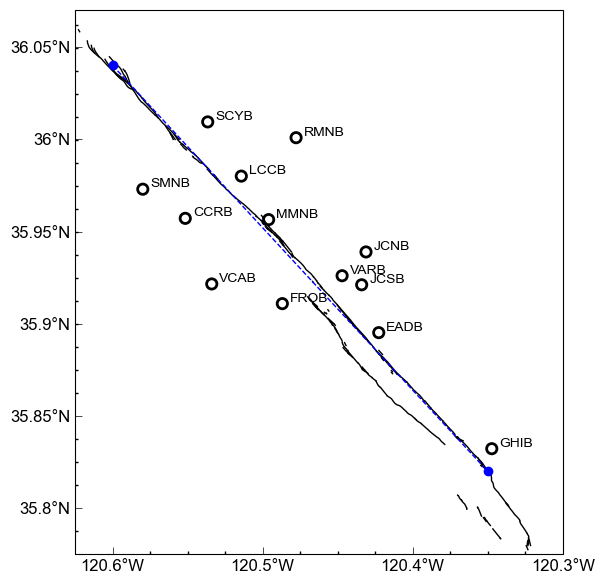

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6), subplot_kw={'projection': ccrs.Mercator()})
f_lon_min = -120.625
f_lon_max = -120.3
f_lat_min = 35.775
f_lat_max = 36.07

#---Plot stations---#
for k, row in df_locorigin.iterrows():
    staid = row.id
    sta = row.station
    lon, lat, elevation, depth = row.longitude, row.latitude, row.elevation, row.depth
    ax.scatter(lon,lat, s=55, facecolors='none',  edgecolors='black',
                    linestyle="-", linewidth=2, zorder=6, transform=ccrs.PlateCarree())
    ax.text(lon+0.005, lat+0.001, sta, fontsize=10, transform=ccrs.PlateCarree())


#---plot fault geometry---#
for sfkey in dict_sf:
    faultx = dict_sf[sfkey][0]
    faulty = dict_sf[sfkey][1]
    min_x, min_y = [np.min(faultx), np.min(faulty)]
    max_x, max_y = [np.max(faultx), np.max(faulty)]

    if (min_x > f_lon_min) & (max_x < f_lon_max) & (min_y > f_lat_min) & (max_y < f_lat_max):
        ax.plot(faultx, faulty, 'k', ls="-", lw=1.0, zorder=-2, transform=ccrs.PlateCarree())
#-------------------------------#

#---Plot approximated fault loc---#
ax.plot([approx_faultloc[0], approx_faultloc[2]], [approx_faultloc[1], approx_faultloc[3]],
            'bo', ls="--", lw=1.0, zorder=-2, transform=ccrs.PlateCarree())
#-------------------------------------------#

ax.set_extent([f_lon_min, f_lon_max, f_lat_min, f_lat_max], crs=ccrs.PlateCarree())

ax.set_xticks(np.arange(-120.6, -120.2, 0.1), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(35.8, 36.075, 0.05), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True, dms=False)
lat_formatter = LatitudeFormatter(dms=False)
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

fig.tight_layout()

plt.savefig(output_imgdir+"/BPnetwork_stationloc_cartopy.png", format="png", dpi=300, bbox_inches="tight")


**NOTE:** scalebar is not implemented in the cartopy module (https://github.com/SciTools/cartopy/issues/490).
There is a function provided here:
https://stackoverflow.com/questions/32333870/how-can-i-show-a-km-ruler-on-a-cartopy-matplotlib-plot

It would work to plot the scale, but we switch to use GMT to plot the map to make sure the scale bar on the map.
In the following cells we continue to use the cartopy to evaluate the distance to the approximated fault trace

# Compute the fault normal distance
**How to compute:**
1. make a small grid along the approximated fault.
2. Compute the geographical distance between the grid and station
3. Take the minimum value as the perpendicular distance.


In [9]:
# Test compute distance
# CCRB, 35.95718, -120.55158
# LCCB, 35.98006, -120.51423
geodesic = cgeo.Geodesic()

a_phys = [-120.55158, 35.95718]
b_phys = [-120.51423, 35.98006]
dist = geodesic.inverse(a_phys, b_phys)[0, 0]
print(f"{dist} m")
# Ref for validation: https://www.movable-type.co.uk/scripts/latlong.html
# 4.216 km (ignoring ellipsoidal effects) 

4218.405971782997 m


In [10]:
approx_faultloc

[-120.6, 36.04, -120.35, 35.82]

In [11]:
R = np.linalg.norm([approx_faultloc[2]-approx_faultloc[0], approx_faultloc[3]-approx_faultloc[1]])
theta = np.arctan2(approx_faultloc[3]-approx_faultloc[1], approx_faultloc[2]-approx_faultloc[0])

In [12]:
ds = 0.001
apprfault_lon = []
apprfault_lat = []
for r0 in np.arange(0, R, step=ds):
    apprfault_lon.append(approx_faultloc[0] + r0*np.cos(theta))
    apprfault_lat.append(approx_faultloc[1] + r0*np.sin(theta))
Napprfault = len(apprfault_lon)

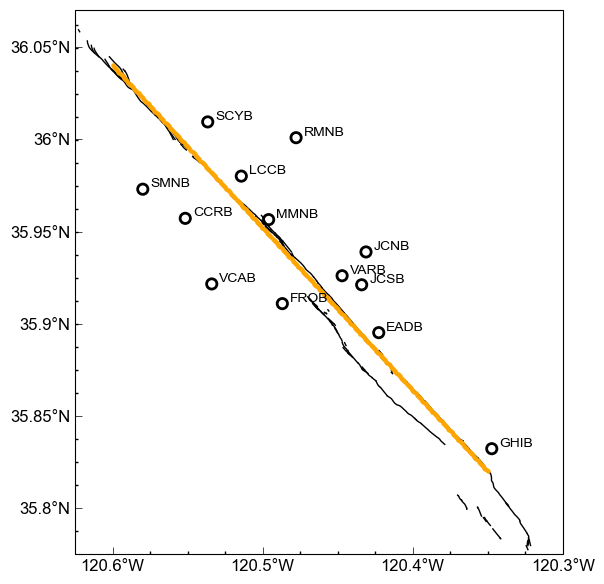

In [13]:
# plot grids on the approximated fault
fig, ax = plt.subplots(1, 1, figsize=(6, 6), subplot_kw={'projection': ccrs.Mercator()})
f_lon_min = -120.625
f_lon_max = -120.3
f_lat_min = 35.775
f_lat_max = 36.07

#---Plot stations---#
for k, row in df_locorigin.iterrows():
    staid = row.id
    sta = row.station
    lon, lat, elevation, depth = row.longitude, row.latitude, row.elevation, row.depth
    ax.scatter(lon,lat, s=55, facecolors='none',  edgecolors='black',
                    linestyle="-", linewidth=2, zorder=6, transform=ccrs.PlateCarree())
    ax.text(lon+0.005, lat+0.001, sta, fontsize=10, transform=ccrs.PlateCarree())


#---plot fault geometry---#
for sfkey in dict_sf:
    faultx = dict_sf[sfkey][0]
    faulty = dict_sf[sfkey][1]
    min_x, min_y = [np.min(faultx), np.min(faulty)]
    max_x, max_y = [np.max(faultx), np.max(faulty)]

    if (min_x > f_lon_min) & (max_x < f_lon_max) & (min_y > f_lat_min) & (max_y < f_lat_max):
        ax.plot(faultx, faulty, 'k', ls="-", lw=1.0, zorder=-2, transform=ccrs.PlateCarree())
#-------------------------------#

#---Plot approximated fault loc---#
ax.scatter(apprfault_lon, apprfault_lat,  5, 'orange',  transform=ccrs.PlateCarree())
#-------------------------------------------#

ax.set_extent([f_lon_min, f_lon_max, f_lat_min, f_lat_max], crs=ccrs.PlateCarree())

ax.set_xticks(np.arange(-120.6, -120.2, 0.1), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(35.8, 36.075, 0.05), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True, dms=False)
lat_formatter = LatitudeFormatter(dms=False)
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

fig.tight_layout()

# plt.savefig(output_imgdir+"/BPnetwork_stationloc_cartopy.png", format="png", dpi=300, bbox_inches="tight")


In [14]:
df_stadist = pd.DataFrame(columns=["station", "latitude", "longitude", "depth", "faultnormal_dist", "locside"])
for k, row in df_locorigin.iterrows():
#     row = df_locorigin.iloc[2]
    staid = row.id
    sta = row.station
    stlon, stlat, elevation, depth = row.longitude, row.latitude, row.elevation, row.depth

    # compute fault normal distance
    dist_all = []
    geodesic = cgeo.Geodesic()
    for i in range(Napprfault):
        dist_all.append(geodesic.inverse([apprfault_lon[i], apprfault_lat[i]], [stlon, stlat])[0, 0])

    faultnormal_dist = np.min(dist_all)

    # select the side of station
    if sta in ["SMNB", "CCRB", "VCAB", "FROB"]:
        locside="pacific"
    else:
        locside="northamerican"

    datatmp = {'station': [sta], 'latitude': [stlat],  'longitude':[stlon], 'depth':[depth], "faultnormal_dist":[faultnormal_dist/1e3],
                      "locside":[locside]}

    df_stadist = pd.concat([df_stadist, pd.DataFrame.from_dict(datatmp)])
    
    # save to the csv file
    df_stadist.set_index("station").to_csv("../data/BPnetwork_faultnormaldist.csv")

In [15]:
df_stadist

,station,latitude,longitude,depth,faultnormal_dist,locside
0,CCRB,35.95718,-120.55158,251,3.027717,pacific
0,EADB,35.89522,-120.42262,245,0.852322,northamerican
0,FROB,35.91095,-120.48688,284,2.222301,pacific
0,GHIB,35.83225,-120.34728,63,1.103975,northamerican
0,JCNB,35.93897,-120.43112,224,3.583676,northamerican
0,JCSB,35.92117,-120.43400,155,2.052458,northamerican
0,LCCB,35.98006,-120.51423,252,1.170606,northamerican
0,MMNB,35.95650,-120.49600,221,0.603893,northamerican
0,RMNB,36.00087,-120.47772,73,5.155094,northamerican
0,SCYB,36.00942,-120.53661,252,1.897192,northamerican
